In [267]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})

In [305]:
cases = []

#Flat bands 
δ   = 0
g_Φ = 0 # can be any?
g_c = 1 # can be any        
g_q = g_c 
E_flat_bands = np.sqrt(g_Φ**2 + (g_c + g_q)**2 )
cases.append([δ, g_Φ, g_c, g_q])

#Dirac point at +- pi
g_Φ = 0
g_q = 1   # can be any
g_c = 1   # can be any
g_x = g_c*g_q
g_p = g_c+g_q
δ = 2 * (g_q+g_c) 
cases.append([δ, g_Φ, g_c, g_q])

#Dirac point at 0
g_Φ = 0
g_q = 1   # can be any
g_c = 1   # can be any
g_x = g_c*g_q
g_p = g_c+g_q
δ = -2 * (g_q+g_c)
cases.append([δ, g_Φ, g_c, g_q])

# D = δ**2/4 + g_Φ**2 + 4*g_x
# cos_k = (-δ*g_p + np.sqrt( δ**2*g_p**2 - 4*(g_p**2-4*g_x)*D ) )/(2*(g_p**2-4*g_x))
# k_dirac = np.arccos(cos_k  )
# δ, cos_k, k_dirac
# 
# δ = +np.sqrt(1/g_x * (g_p**2 * (g_Φ**2+4*g_x) - 4*g_x*g_Φ**2-16*g_x**2))  


In [306]:
# Bloch sphere for plots
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

In [307]:
k_values = np.linspace(-np.pi, np.pi, 101)
H_k  = np.zeros([len(cases), len(k_values), 2, 2], dtype = 'complex')
E_k  = np.zeros([len(cases), len(k_values), 2])

σx, σy, σz = sq_ext.pauli_matrices()

for i, case in enumerate(cases):
    δ, g_Φ, g_c, g_q = case
    for j, k in enumerate(k_values):
        H_k[i,j] = sq_ext.Hk_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k)
        # E_k[i,j,0] = -np.sqrt((δ/2 + (g_c+g_q)*np.cos(k))**2  +  g_Φ**2   + (2 * np.sqrt(g_c*g_q) * np.sin(k))**2 ) 
        # E_k[i,j,1] = +np.sqrt((δ/2 + (g_c+g_q)*np.cos(k))**2  +  g_Φ**2   + (2 * np.sqrt(g_c*g_q) * np.sin(k))**2 ) 
        E_k[i,j] = np.linalg.eigh(H_k[i,j])[0]


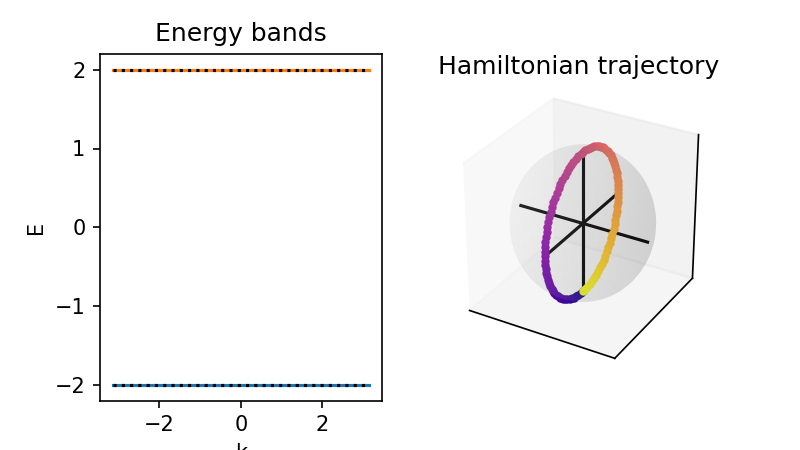

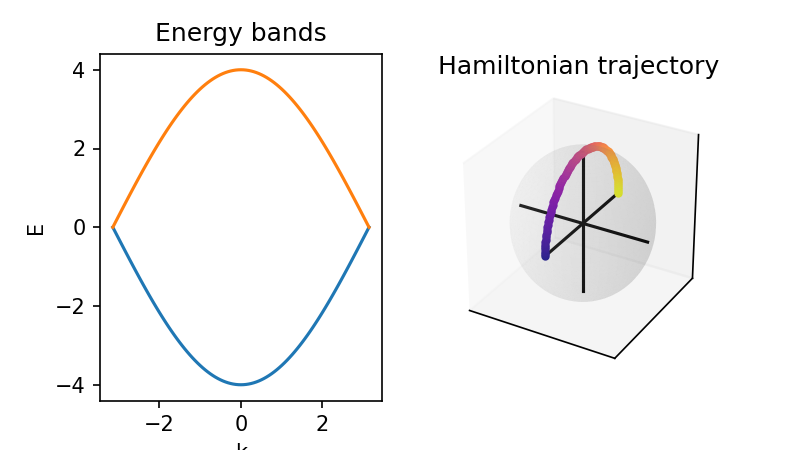

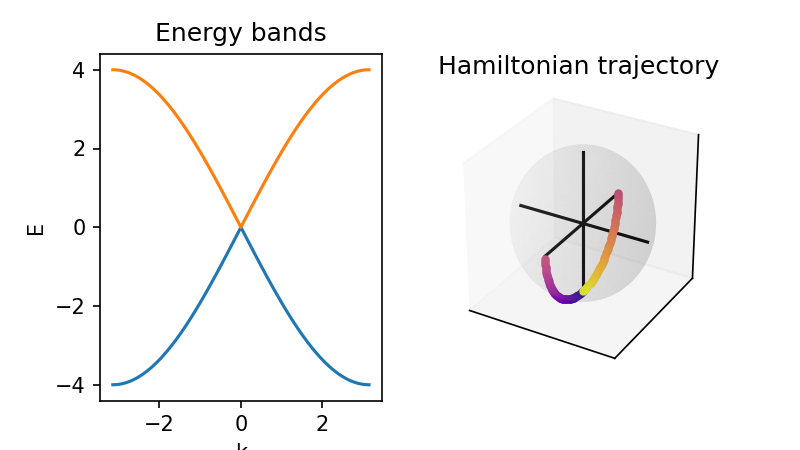

In [308]:
colors = figs.generate_colors_from_colormap(len(k_values), 'plasma')

for i, case in enumerate(cases): 
    fig = plt.figure(figsize=(8/3 * 2, 3), dpi=150)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Energy bands")
    ax2 = fig.add_subplot(1,2, 2, projection='3d')
    ax2.set_title("Hamiltonian trajectory")
    
    ax = [ax1, ax2]
    
    #Energy bands
    ax[0].plot(k_values, E_k[i, :, 0])
    ax[0].plot(k_values, E_k[i, :, 1])
    ax[0].set_ylabel('E')
    ax[0].set_xlabel('k')
    # ax.set_title(f'$\delta = {np.round(δ_values[δ_index],2)}$')
    # ax.set_ylim([-40,50])
    if i==0:
        ax[0].plot(k_values, E_flat_bands*np.ones_like(k_values),':k')
        ax[0].plot(k_values, -E_flat_bands*np.ones_like(k_values),':k')
        
        
    #Trajectory in bloch sphere
    ax[1].plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.1)
    ax[1].plot([-1,1], [0,0], [0,0],'k')
    ax[1].plot([0,0],[-1,1],  [0,0],'k')
    ax[1].plot( [0,0], [0,0],[-1,1],'k')
    
    
    hx, hy, hz  = [ np.zeros(len(k_values)) for _ in range(3)]
    for j in range(len(k_values)):
        _, hx[j], hy[j], hz[j] =  sq_ext.decomposition_in_pauli_2x2(H_k[i,j])
        
    norm = np.sqrt(hx**2 + hy**2 + hz**2)
    hx /= norm
    hy /= norm
    hz /= norm
    
            # Plot trajectory 
    for j in range(len(k_values)):
        ax[1].plot(hx[j], hy[j], hz[j],'.', color=colors[j])

    # ax[1].set_xlabel(r'$\sigma_x$')
    # ax[1].set_ylabel(r'$\sigma_y$')
    # ax[1].set_zlabel(r'$\sigma_z$')
    ax[1].set_box_aspect([1,1,1])
    # ax[1].set_xlim([-1,1])
    # ax[1].set_ylim([-1,1])
    # ax[1].set_zlim([-1,1])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_zticks([])
    
# fig.tight_layout()

In [650]:
plt.close('all')

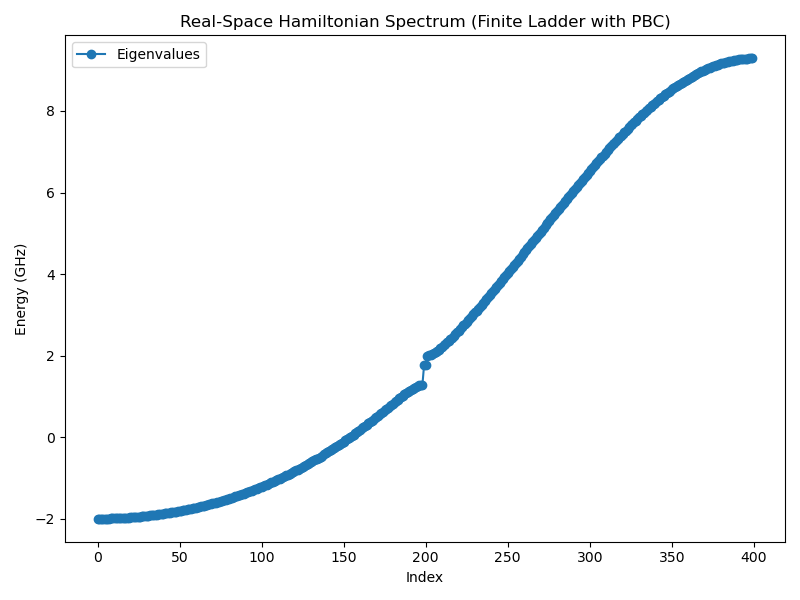

In [849]:
# System parameters (example values in GHz)
# Flat bands
# omega_c =  1 # Onsite frequency for mode a (resonator)
# omega_q =  1  # Onsite frequency for mode b (qubit)
# gΦ   =  0.1 # Intra-cell coupling between a and b
# g_cc    =  1 # Hopping between adjacent a modes
# g_qq    =  1  # Hopping between adjacent b modes
# g_qc    =  1  # Cross-coupling between b_n and a_{n+1} (and vice versa with opposite sign)

# Closing gap
# Test
δ_transition = 2 * np.sqrt(gcc_by_gq**2 + gqq_by_gq**2 + gcc_by_gq*gqq_by_gq )
omega_c =  0 # Onsite frequency for mode a (resonator)
gΦ   =  0 # Intra-cell coupling between a and b
g_cc    =  1 # Hopping between adjacent a modes
g_qq    =  2  # Hopping between adjacent b modes
g_qc    =  np.sqrt(g_cc * g_qq)  # Cross-coupling between b_n and a_{n+1} (and vice versa with opposite sign)

δ_transition = 2 * np.sqrt(g_cc**2 + g_qq**2 + g_cc*g_qq )
omega_q = δ_transition

#Nontrivial loop around a pole
# omega_c =  11 # Onsite frequency for mode a (resonator)
# omega_q =  1  # Onsite frequency for mode b (qubit)
# gΦ   =  0.5  # Intra-cell coupling between a and b
# g_cc    =  4.44 # Hopping between adjacent a modes
# g_qq    =  4.44  # Hopping between adjacent b modes
# g_qc    =  4.44  # Cross-coupling between b_n and a_{n+1} (and vice versa with opposite sign)

# g_cc = (-(omega_c - omega_q) - np.sqrt( (omega_c - omega_q)**2 - 4 * gΦ**2 ))/4
# g_qq = g_cc
# Number of unit cells
N = 200

# Total Hilbert space dimension: 2 modes per cell
dim = 2 * N

# Initialize the Hamiltonian matrix (complex valued)
H_real = np.zeros((dim, dim), dtype=np.complex128)

# Helper function to implement periodic boundary conditions:
def pbc(n, N):
    return n % N

# Loop over unit cells to build H_real
for n in range(N):
    # Basis ordering: index 2*n for mode a, index 2*n+1 for mode b at cell n.
    idx_a = 2 * n      # mode a in cell n
    idx_b = 2 * n + 1  # mode b in cell n

    # Onsite terms
    H_real[idx_a, idx_a] += omega_c
    H_real[idx_b, idx_b] += omega_q

    # Intra-cell (onsite) coupling between a and b (and its Hermitian conjugate)
    H_real[idx_a, idx_b] += gΦ
    H_real[idx_b, idx_a] += gΦ

    # Inter-cell couplings: couple cell n with cell n+1 (with periodic BC)
    # Determine indices for cell n+1 using periodic boundary conditions:
    n_next = pbc(n + 1, N)
    idx_a_next = 2 * n_next      # a in cell n+1
    idx_b_next = 2 * n_next      + 1  # b in cell n+1

    if n==N-1:
        continue
    # Coupling between adjacent a modes (resonators): g_cc (real, + sign)
    H_real[idx_a, idx_a_next] += g_cc
    H_real[idx_a_next, idx_a] += g_cc

    # Coupling between adjacent b modes (qubits): g_qq (real, - sign)
    H_real[idx_b, idx_b_next] += -g_qq
    H_real[idx_b_next, idx_b] += -g_qq

    # Cross-coupling: from b in cell n to a in cell n+1: -g_qc
    H_real[idx_b, idx_a_next] += -g_qc
    H_real[idx_a_next, idx_b] += -g_qc

    # Cross-coupling: from a in cell n to b in cell n+1: +g_qc
    H_real[idx_a, idx_b_next] += g_qc
    H_real[idx_b_next, idx_a] += g_qc


# Diagonalize the Hamiltonian
eigvals, eigvecs = np.linalg.eig(H_real)
eigvals = np.sort(np.real(eigvals))  # sorting eigenvalues

# Plot the eigenvalue spectrum
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(dim), eigvals, 'o-', label='Eigenvalues')
ax.set_xlabel('Index')
ax.set_ylabel('Energy (GHz)')
ax.set_title('Real-Space Hamiltonian Spectrum (Finite Ladder with PBC)')
ax.legend()
fig.tight_layout()


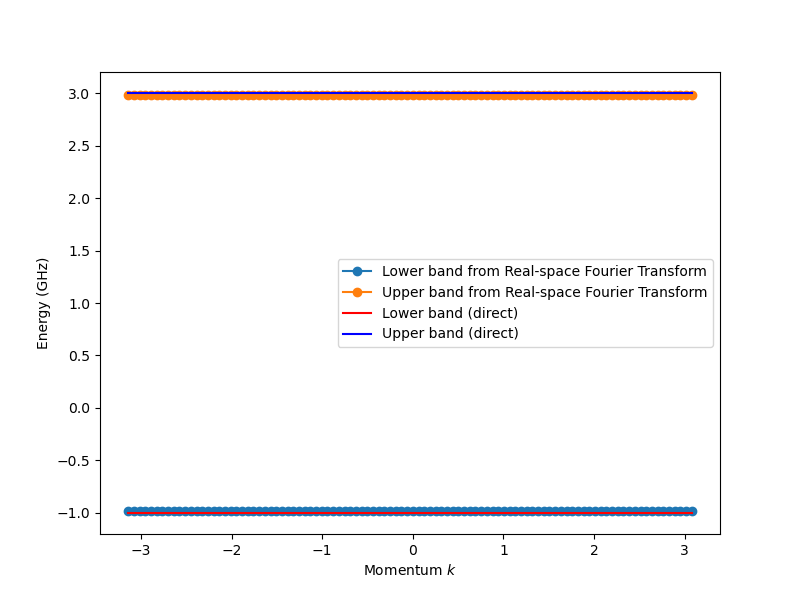

In [839]:
# Create the Fourier transform matrix F for the cell indices (N x N)
F = np.zeros((N, N), dtype=np.complex128)
for n in range(N):
    for m in range(N):
        k = 2 * np.pi * m / N  # allowed discrete momentum
        F[n, m] = np.exp(1j * k * n) / np.sqrt(N)

# Build the full Fourier transform matrix U for the 2N-dimensional space:
# U = F \otimes I_2
I2 = np.eye(2, dtype=np.complex128)
U = np.kron(F, I2)

# Transform the real-space Hamiltonian into momentum space
H_mom = U.conj().T @ H_real @ U

# Now, H_mom should be block-diagonal.
# Extract the 2x2 blocks for each momentum value:
Hk_blocks = np.zeros((N, 2, 2), dtype=np.complex128)
eigvals_mom = np.zeros((N, 2))
for m in range(N):
    # The block corresponding to momentum k = 2pi*m/N is:
    Hk_blocks[m] = H_mom[2*m:2*m+2, 2*m:2*m+2]
    eigvals = np.linalg.eigvals(Hk_blocks[m])
    eigvals_mom[m] = np.sort(np.real(eigvals)) #- np.mean(np.real(eigvals))

# Construct corresponding k values
k_vals = np.array([2*np.pi*m/N for m in range(N)])#-np.pi

# Plot the momentum-space bands from the block diagonalization
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(k_vals-np.pi, eigvals_mom[:, 0], 'o-', label='Lower band from Real-space Fourier Transform')
ax.plot(k_vals-np.pi, eigvals_mom[:, 1], 'o-', label='Upper band from Real-space Fourier Transform')
ax.set_xlabel('Momentum $k$')
ax.set_ylabel('Energy (GHz)')

# For comparison, we also construct the momentum-space Hamiltonian directly:
E_band1 = np.zeros(N)
E_band2 = np.zeros(N)
for m, k in enumerate(k_vals):
    M_k = np.array([[omega_c + 2*g_cc*np.cos(k), gΦ + 1j*2*g_qc*np.sin(k)],
                    [gΦ - 1j*2*g_qc*np.sin(k), omega_q - 2*g_qq*np.cos(k)]])

    # M_k = ((omega_c-omega_q)/2 + (g_cc +g_qq )*np.cos(k)) * σz + \
    #        gΦ * σx + 2 * g_qc * np.sin(k) * σy 
    
    eigvals = np.linalg.eigvals(M_k)
    eigvals = np.sort(np.real(eigvals))
    E_band1[m] = eigvals[0]
    E_band2[m] = eigvals[1]

ax.plot(k_vals-np.pi, E_band1, 'r-', label='Lower band (direct)')
ax.plot(k_vals-np.pi, E_band2, 'b-', label='Upper band (direct)')

ax.legend()

In [840]:
# Assume you already have H_real and N, dim, etc., from your existing code.

# 1) Diagonalize H_real
eigvals_real, eigvecs_real = np.linalg.eig(H_real)
eigvals_real = np.real(eigvals_real)
idx_sort = np.argsort(eigvals_real)
eigvals_sorted = eigvals_real[idx_sort]
eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors

Chosen eigenvalue ~ 1.1000000000000005


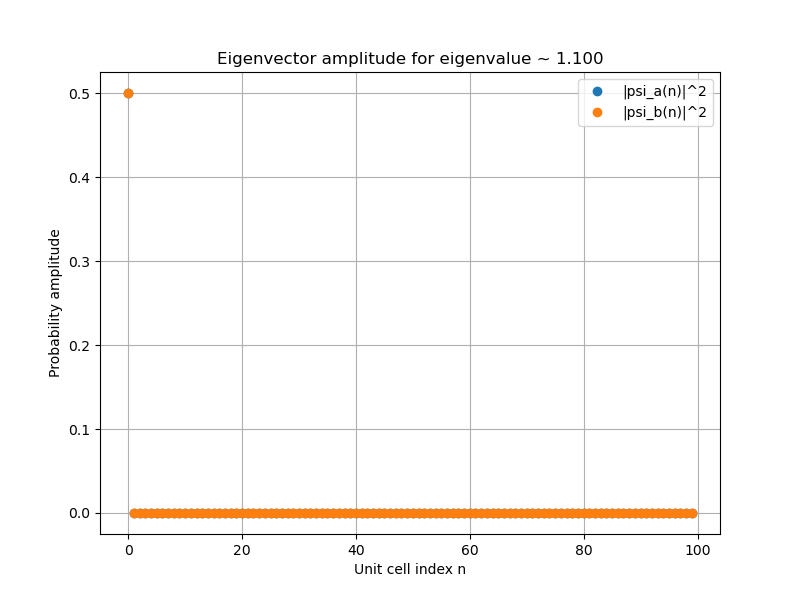

In [841]:

# 2) Pick an eigenstate index, for example the middle of the spectrum if there's a gap
mid_index = dim // 2# or any other index of interest
# mid_index = 0 # or any other index of interest
eigenvalue_of_interest = eigvals_sorted[mid_index]
eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column

print(f"Chosen eigenvalue ~ {eigenvalue_of_interest}")

# 3) Separate amplitude for each site, recall basis: 2n -> a_n, 2n+1 -> b_n
amplitudes_a = []
amplitudes_b = []
for n in range(N):
    amp_a_n = eigenvector_of_interest[2*n]
    amp_b_n = eigenvector_of_interest[2*n+1]
    amplitudes_a.append(np.abs(amp_a_n)**2)
    amplitudes_b.append(np.abs(amp_b_n)**2)

# 4) Plot to see if it is localized near boundaries
sites = np.arange(N)  # site index
plt.figure(figsize=(8,6))
plt.plot(sites, amplitudes_a, 'o', label='|psi_a(n)|^2')
plt.plot(sites, amplitudes_b, 'o', label='|psi_b(n)|^2')
plt.xlabel('Unit cell index n')
plt.ylabel('Probability amplitude')
plt.title(f'Eigenvector amplitude for eigenvalue ~ {eigenvalue_of_interest:.3f}')
plt.legend()
plt.grid(True)
plt.show()
